# Toy Problem #1


Approach: Read the data in from the csv files.

- Create a GeoDataFrame object out of this
- Create a dual graph so that each node represents a street and the geometries between them
- Use VRP process on nodes

New Heuristics Approach: based on https://researchrepository.wvu.edu/cgi/viewcontent.cgi?article=5362&context=etd



# Step 1 - Read Data and Create Graph

In [1]:
import networkx as nx
import math
import pandas as pd
import random
import osmnx as ox
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import itertools
import numpy as np

c:\Users\Sneez\Desktop\Snowplowing\Snowplow-Routing-Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read the edges and nodes

In [2]:
edgelist = pd.read_csv("edges.csv")
nodelist = pd.read_csv("nodes.csv")

Create graph

In [3]:
G = nx.Graph()
for i,edges in edgelist.iterrows():
    G.add_edge(edges.iloc[0],edges.iloc[1],**edges.iloc[2:].to_dict())

for i,nodes in nodelist.iterrows():
    attributes = nodes[1:].to_dict()
    nx.set_node_attributes(G, {nodes['id']:  attributes})  


Take a step back and visualize the data in our graph

In [4]:
print('# of edges: {}'.format(G.number_of_edges()))
print('# of nodes: {}'.format(G.number_of_nodes()))

print(G.edges(data=True))
print(G.nodes(data=True))

# of edges: 6
# of nodes: 5
[('depot', 'home', {'distance': 1, 'priority': 1, 'time': 1, 'passes_rem': 1, 'salt_per': 1}), ('depot', 'school', {'distance': 2, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), ('depot', 'grocery', {'distance': 7, 'priority': 2, 'time': 7, 'passes_rem': 1, 'salt_per': 3}), ('school', 'grocery', {'distance': 5, 'priority': 2, 'time': 5, 'passes_rem': 1, 'salt_per': 2}), ('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes_rem': 2, 'salt_per': 1}), ('grocery', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes_rem': 2, 'salt_per': 1})]
[('depot', {'x': 0, 'y': 0}), ('home', {'x': 1, 'y': 0}), ('school', {'x': 0, 'y': 2}), ('grocery', {'x': 5, 'y': 2}), ('hospital', {'x': 3, 'y': 7})]


##### Visualize the Graph

In [5]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}
# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])


{'depot': (0, 0),
 'home': (1, 0),
 'school': (0, 2),
 'grocery': (5, 2),
 'hospital': (3, 7)}

Now plot

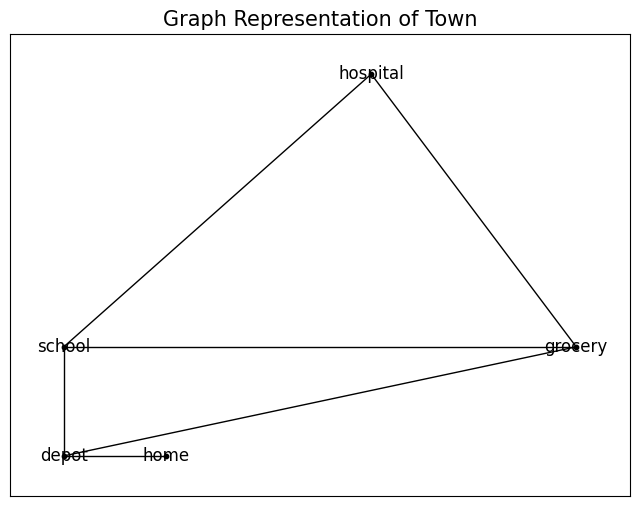

In [6]:
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True)
plt.title('Graph Representation of Town', size=15)
plt.show()

Visualize Paramters

In [7]:
for edge in G.edges(data=True):
    print(edge)

('depot', 'home', {'distance': 1, 'priority': 1, 'time': 1, 'passes_rem': 1, 'salt_per': 1})
('depot', 'school', {'distance': 2, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1})
('depot', 'grocery', {'distance': 7, 'priority': 2, 'time': 7, 'passes_rem': 1, 'salt_per': 3})
('school', 'grocery', {'distance': 5, 'priority': 2, 'time': 5, 'passes_rem': 1, 'salt_per': 2})
('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes_rem': 2, 'salt_per': 1})
('grocery', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes_rem': 2, 'salt_per': 1})


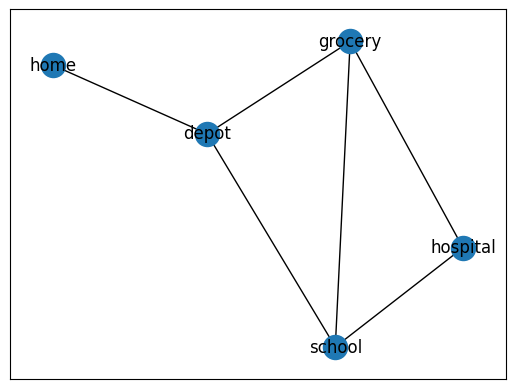

In [8]:
# Set the seed for the spring layout
spring_pos = nx.spring_layout(G, seed=1)

# Draw the graph using the spring layout
nx.draw_networkx(G, pos=spring_pos, with_labels=True)
plt.show()

# Step 2: Route Construction Algorithm (RCA)

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  RCL |  Restricted Candidate List |
|  $\alpha$   |  Threshold parameter. Value between 0 and 1  
|  C<sub>min   | Lowest incremental cost of a candidate element to be added to the partial solution    |
| C<sub>max | Highest incremental cost of a candidate element to be added to the partial solution|
| S_i | Amount of salt required to service road i |
|E| List of possible candidates that can be added to the partial solution
|No_Routes|Number of routes developed in the network



Adding salt considerations.

Overview:
1. If there is at least one required arc from the current node, then create a restricted candidate list based on the neighbors of the current node. Otherwise go to step 3
2. If RCL is empty, go to step 3. Otherwise choose a random arc from the RCL based on the threshold parameter and cost range
3. Go through the list of all required arcs and find the closest one.
4. Service that arc, subtracting one from the effective degree of the current node
5. Update the current node to the new node

## Identifying Turn Directions at an Intersection

Methodology: Use coordinate system. Identify the three coordinates of the triangle (can be degenerate) that every turn makes. Potential for linear algebra: dot product of the two vectors, or change of basis?

Example: going from (2,1) to (0,1) to (-1,-1)

v = [-2, 0]
w = [-1, -2]

Create a function that computes the signed angle between any two vectors

In [9]:
from math import atan2
from math import pi
def angle(v, w):
    '''
    Computes the signed angle (in degrees) between two vectors v and w
    '''
    dot = v[0]*w[0] + v[1]*w[1]     # Dot product between [x1, y1] and [x2, y2]
    det = v[0]*w[1] - v[1]*w[0]      # Determinant
    angle = atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

    return angle*180/pi

v=(1,0)
w=(0,-1)

angle(v,w)


-90.0

Using the angle, identify whether the turn is straight, left, right, or backwards. See diagram for reference
<img src="turn_categorization.jpg" alt="Turn Categorization Based on Angle" />


In [10]:
def turn_direction(angle):
    '''
    Returns the direction of a turn given an angle
    '''
    if angle < 15 and angle > -15:
        return "straight"
    elif angle >= -90 and angle <= -15:
        return "right"
    elif angle <= 90 and angle >= 15:
        return "left"
    elif angle <= 135 and angle > 90:
        return "sharp left"
    elif angle >= -135 and angle < -90:
        return "sharp right"
    else:
        return "u-turn"


71.56505117707799 left


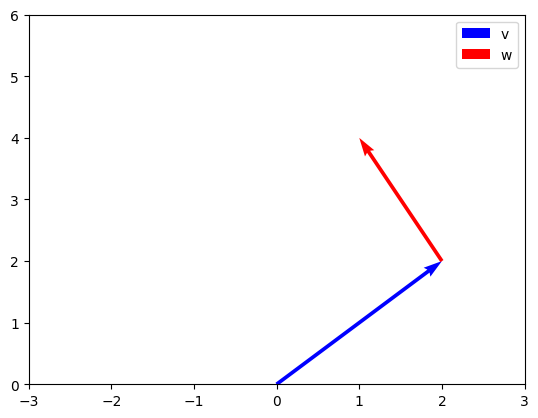

In [11]:
v=(2,2)
w=(-1,2)
theta = angle(v,w)
print(theta, turn_direction(theta))

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the vectors
ax.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='blue', label='v')
ax.quiver(v[0], v[1], w[0], w[1], angles='xy', scale_units='xy', scale=1, color='red', label='w')

# Set the x and y limits
ax.set_xlim([-3, 3])
ax.set_ylim([0, 6])

# Add a legend
ax.legend()

# Show the plot
plt.show()

Initialize model parameters

In [12]:
number_of_routes = 0 # set initial number of routes to zero
curr_node = 'depot' # set starting node to depot
alpha = 0.4 # set alpha parameter
SALT_CAP = 5 # fixed salt cap of the vehicle

Update the effective degree of all nodes. If $v$ is the vertice and $E_v$ is the set of all edges leaving from $v$, then the effective degree is 
$$\text{Deg(v)} = \sum_{e \in E_v} e(\text{passes})$$

Also, calculate the weighted degree of each node, defined as
$$\text{WeightedDeg(v)} = \sum_{e \in E_v} e(\text{passes})\cdot e(\text{priority})$$

Also, update the total amount of salting required for the road given the number of passes

In [13]:
def config_graph_attributes(G):
    for node in G.nodes:
        eff_deg = 0
        weight_deg = 0
        for edge in G.edges([node], data=True):
            eff_deg += edge[2]['passes_rem']
            weight_deg += edge[2]['passes_rem']*edge[2]['priority']
        G.nodes[node]['effective_degree'] = eff_deg
        G.nodes[node]['weighted_degree'] = weight_deg
    # print result
        
    for edge in G.edges(data=True):
        edge[2]['salt_tot'] = edge[2]['passes_rem']*edge[2]['salt_per']

    # add a new attribute to each edge, called "deadheading_passes" and initially set to 0
    for edge in G.edges(data=True):
        edge[2]['deadheading_passes'] = 0

config_graph_attributes(G)


Calculate shortest distance between each pair of nodes in the network using
Floyd's algorithm and visualize distance matrix

Define a cost function for traversing an arc

In [14]:
def cost(G, node1, node2):
    '''
    Returns the cost of traversing an edge between two nodes. Doesn't include priorities yet. 
    Currently based solely on distance.
    '''
    edge_data = G.get_edge_data(node1, node2)

    cost = edge_data['distance']
    return cost

In [15]:
def needs_servicing(G, node1, node2):
    '''
    Returns whether or not the edge between two nodes requires servicing
    '''
    return G[node1][node2]['passes_rem'] > 0

### Start finding a route

Check if there are any required arcs remaining departing from the current node

In [16]:
for edge in G.edges():
    print(edge)
print(G['school']['depot'])

('depot', 'home')
('depot', 'school')
('depot', 'grocery')
('school', 'grocery')
('school', 'hospital')
('grocery', 'hospital')
{'distance': 2, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1, 'salt_tot': 1, 'deadheading_passes': 0}


In [17]:
def visit_arc(G, curr, arc, route, undirected=True):
    global curr_salt
    '''
    Visits an arc and updates the route and cost. Returns the new node that the arc is on
    
    Parameters:
        G (networkx.Graph): The graph representing the network
        arc (tuple): The arc to be visited
        route (list): The partial route taken so far (default: partial_route)
        c (float): The partial cost incurred so far (default: partial_cost)
        undirected (bool): Flag indicating if the graph is undirected (default: True)
    
    Returns:
        string: The new node that the arc is on
    '''

    # identify the direction of traversal
    from_node = arc[0] if arc[0] == curr else arc[1]
    to_node = arc[0] if arc[0] != curr else arc[1]
    
    # not deadheading. So we service the arc and update the effective degree of the relevant node
    # need a check to see if we can actually service the arc given the amount of salt we have left.
    salt_required = G[from_node][to_node]['salt_per']

    # needs servicing and we can service it. Update weighted and effective degree
    if needs_servicing(G, from_node, to_node) and curr_salt >= salt_required:
        G.nodes[from_node]['weighted_degree'] -= G[from_node][to_node]['priority']
        G.nodes[from_node]['effective_degree'] -= 1

        if (undirected):
            G.nodes[to_node]['effective_degree'] -= 1
            G.nodes[to_node]['weighted_degree'] -= G[from_node][to_node]['priority']

        curr_salt -= salt_required
        G[from_node][to_node]['salt_tot'] -= salt_required    
        G[from_node][to_node]['passes_rem'] -= 1 # mark that we traversed this arc

    else:
        G[from_node][to_node]['deadheading_passes'] += 1
    route.append((from_node, to_node))
    return to_node

In [18]:
def process_node(G, curr_node):
    '''
    Returns a list of required arcs that depart from curr_node, as well as the minimum and maximum cost
    of all departing arcs
    '''
    c_min = math.inf
    c_max = -math.inf

    required = []
    for edge in G.edges([curr_node], data=True):
        if edge[2]["passes_rem"] > 0:
            required.append(edge)
            c_min = min(cost(G, edge[0], edge[1]), c_min)
            c_max = max(cost(G, edge[0], edge[1]), c_max)
    return required, c_min, c_max

In [19]:
def move_between_nodes(G, G_dual, node1, node2, route_up_to_now):
    '''
    Moves between two nodes via the shortest path, updating any required arcs along the way. 
    Works for non-multigraphs. Requires modification when doing it for multigraphs since floyd_warshall
    only returns nodes, not edges in the shortest path.
    '''
    node_path = nx.dijkstra_path(G_dual, str(node1)+"_source", str(node2)+"_source", weight="weight")
    
    edges = [edge for edge in node_path if type(edge) == tuple] # ignore source nodes

    curr = node1
    for edge in edges:
        curr = visit_arc(G, curr, edge, route=route_up_to_now)

In [20]:
def has_edge_within_capacity(G, node):
    global curr_salt
    if curr_salt == 0:
        return False
    for neighbor in G[node]:
        if G[node][neighbor]['salt_per'] <= curr_salt and G[node][neighbor]['passes_rem'] > 0:
            return True
    return False

def find_nearest_required(G, G_dual, node):
    '''
    Finds the path to the nearest node with a required arc to traverse.
    '''
    dists = dict()
    for target in G.nodes():
        distance = nx.dijkstra_path_length(G_dual, node + "_source", target + "_source", weight="weight")
        dists[target] = distance
    # loop through the dists array and find the nearest required arc
    min_dist = math.inf
    min_dist_node = None
    for target in G.nodes():
        if target == node:
            continue
        if G.nodes[target]['effective_degree'] > 0 and dists[target] < min_dist:
            # check that the node has an edge to service within salt capacity
            if has_edge_within_capacity(G, target):
                min_dist = dists[target]
                min_dist_node = target
    
    if min_dist_node is None:
        return None
    # reconstruct path
    node_path = nx.dijkstra_path(G_dual, str(node)+"_source", str(min_dist_node)+"_source", weight="weight")
    edges = [edge for edge in node_path if type(edge) == tuple] # ignore source nodes
    return edges
        

Add an arc to the RCL if it has a cost in the range 
$$R = [C_{min}, C_{min} + \alpha \cdot (C_{max}-C_{min})]$$

Determine C<sub>min</sub> and C<sub>max</sub> by looping through first.

A value of alpha close to zero means that we will almost always choose the least cost arc (think greedy), while value close to one means the choice will be virtually random. Alpha=zero is nearest neighbor heuristic

To choose an arc from the RCL, we either randomly choose or weight based on turn direction and degree of the next intersection.

Parameter: Weights is the amount of weight assigned to turning, degree, and priority. Total weight is 

$$(\text{weights[0]}) \cdot \text{turns} + (\text{weights[1]})\cdot \text{degree} + (\text{weights[2]})\cdot \text{priority}$$

Continue running the route construction algorithm until there are no required nodes in the graph left. Run the algorithm on a copy of G so that the original graph is preserved

In [21]:
def chooseArc(G, rcl, prev_node, weights):
    """
    Selects an arc from a Restricted Candidate List (RCL) based on various weights.

    Parameters:
    - G: The graph representing the road network.
    - rcl: The Restricted Candidate List (RCL) containing the arcs to choose from.
    - prev_node: The previous node in the path.
    - weights: A list of weights used to calculate the arc selection probabilities. The first weight is for turn direction, the second weight is for the degree of the next node, and the third weight is for the priority of the arc.
    Precondition: sum of weights is 1.

    Returns:
    - The selected arc from the RCL.

    Algorithm:
    1. If the previous node is None or a random number is greater than 0.8, choose an arc randomly from the RCL.
    2. Calculate weights for each arc in the RCL based on turn direction, degree of the next node, and priority.
    3. Normalize the sum of the weights.
    4. Choose an arc based on the weights, where higher weights are more likely to be chosen.

    Note:
    - The angle, turn_direction, and angle functions are assumed to be defined elsewhere.

    """

    # randomize 20% of the time
    if (random.random() > .8):
        print("randomizing")
        return random.choice(rcl)
    
    turn_weights = {"straight": 6, "right": 5, "left": 4, "sharp right": 3, "sharp left": 2, "u-turn": 1}
    weights_turns = np.empty(len(rcl))
    weights_degrees = np.empty(len(rcl))
    weights_priority = np.empty(len(rcl))

    # calculate weights by turn direction, degree of next node, and priority
    i = 0
    for edge in rcl:
        curr_node = edge[0]
        next_node = edge[1]

        # only calculate turn direction if there is a previous node
        if prev_node is not None:
            v_x = G.nodes[curr_node]['x']-G.nodes[prev_node]['x']
            v_y = G.nodes[curr_node]['y']-G.nodes[prev_node]['y']

            w_x = G.nodes[next_node]['x']-G.nodes[curr_node]['x']
            w_y = G.nodes[next_node]['y']-G.nodes[curr_node]['y']

            v = (v_x, v_y)
            w = (w_x, w_y)

            theta = angle(v,w)

            weights_turns[i] = (turn_weights[turn_direction(theta)])
        weights_degrees[i] = G.nodes[next_node]['weighted_degree']
        weights_priority[i] = G[curr_node][next_node]['priority']
        i+=1


    # normalize the sum of the weights
    weights_degrees = weights_degrees / np.sum(weights_degrees)
    weights_priority = weights_priority / np.sum(weights_priority)

    if prev_node is not None:
        weights_turns = weights_turns / np.sum(weights_turns)
        weights_tot = weights[0]*weights_turns + weights[1]*weights_degrees + weights[2]*weights_priority
    # if there is no previous node, we are at depot, so turn direction doesn't matter.
    else:
        weights_tot = weights[1]*weights_degrees + weights[2]*weights_priority
        weights_tot = weights_tot / np.sum(weights_tot)
    
    print("Weights", weights_tot, "prev node is none?", prev_node is None)
    print("Degree weights", weights_degrees)
    # choose an arc based on the weights (higher weights are more likely to be chosen)
    index = int(np.random.choice(np.linspace(0,len(rcl)-1,len(rcl)), p=weights_tot))
    print("choice: ", rcl[index][0], rcl[index][1])
    print("RCl was ", [(edge[0], edge[1]) for edge in rcl])
    return rcl[index]


In [22]:
def RCA(G, G_dual, curr_node, alpha, arc_selection_weights, route):
    global curr_salt
    while True:
        required_arcs, c_min, c_max = process_node(G, curr_node)
        rcl = [] # initialize restricted candidate list
        
        for edge in required_arcs:
            if cost(G, edge[0], edge[1]) >= c_min and cost(G, edge[0], edge[1]) <= c_min + alpha*(c_max-c_min) and G[edge[0]][edge[1]]['salt_per'] <= curr_salt:
                rcl.append(edge)
        
        # chooes an arc based on restricted candidate list if not empty
        if len(rcl) > 0:
            prev_node = route[-1][0] if len(route) > 0 else None
            chosen_arc = chooseArc(G, rcl, prev_node, arc_selection_weights)
            curr_node = visit_arc(G, curr_node, chosen_arc, route=route)

        # if restricted candidate list is empty, follow path to nearest node with required arc
        else:
            path = find_nearest_required(G, G_dual, curr_node)
            # no more required arcs in the graph that we can service, so we're done.
            # return to the depot and refill salt cap
            if path is None:
                move_between_nodes(G, G_dual, curr_node, 'depot', route)
                return route
            print("current node is ", curr_node, "path is ", path)
            # otherwise go to the arc to visit
            for edge in path:
                curr_node = visit_arc(G, curr_node, edge, route=route)
                print("currnode is ", curr_node)
                if curr_node == 'depot':
                    return route
        # if we're at the depot for any reason, that's the end of a route.
        if curr_node == 'depot':
            return route

In [23]:
def all_serviced(G):
    for node in G.nodes():
        if G.nodes[node]['effective_degree'] > 0:
            return False
    return True

Create dual representation

In [24]:
def identify_cost(G_primal, G_dual, node1, node2):
    '''
    Identifies the cost of traversing from edge1 to edge2
    '''
    # cost is the sum of the weights of the two nodes in the graph (which correspond to edges in the oringal)
    cost = G_dual.nodes[node1]['weight'] + G_dual.nodes[node2]['weight']

    # add the turn penalty cost
    turn_penalty = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}

    first_node = 0
    second_node = 0
    third_node = 0

    # identify which way the edges are being traversed. need to traverse node1->common->node2
    if node1[1] == node2[0]:
        # common node in the middle, traverse by going node1->common->node2
        first_node = node1[0]
        second_node = node1[1]
        third_node = node2[1]
    
    elif node1[0] == node2[1]:
        # common node at the start fo first edge and end of second edge
        first_node = node1[1]
        second_node = node1[0]
        third_node = node2[0]
    
    elif node1[0] == node2[0]:
        # common node the first node of both edges, traverse the first edge first
        first_node = node1[1]
        second_node = node1[0]
        third_node = node2[1]

    elif node1[1] == node2[1]:
        # common node the second node of both edges
        first_node = node1[0]
        second_node = node1[1]
        third_node = node2[0]
    

    v_x = G_primal.nodes[second_node]['x']-G_primal.nodes[first_node]['x']
    v_y = G_primal.nodes[second_node]['y']-G_primal.nodes[first_node]['y']

    w_x = G_primal.nodes[third_node]['x']-G_primal.nodes[second_node]['x']
    w_y = G_primal.nodes[third_node]['y']-G_primal.nodes[second_node]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle(v,w)
    cost += turn_penalty[turn_direction(theta)]

    return cost

In [25]:
def create_dual(G):
    G_dual = nx.DiGraph(name="pseudo-dual")

    # Create nodes in G_dual for each edge in G
    for edge in G.edges():
        G_dual.add_node(edge, weight=G[edge[0]][edge[1]]['distance'])

    # Create edges in G_dual to represent connections between two edges in G
    for edge1 in G.edges():
        for edge2 in G.edges():
            if edge1 != edge2:
                if edge1[1] == edge2[0] or edge1[0] == edge2[0] or edge1[1] == edge2[1]:

                    # get the weights for traversing in both directions
                    weight1 = identify_cost(G, G_dual, edge1, edge2)
                    weight2 = identify_cost(G, G_dual, edge2, edge1)

                    # add edges to graph
                    G_dual.add_edge(edge1, edge2, weight=weight1)
                    G_dual.add_edge(edge2, edge1, weight=weight2)


    # add source and target nodes
    for node in G:
        G_dual.add_node(str(node) + "_source", weight=0)
    # add edges connecting source and targets to valid gateways
    for node in G_dual.nodes():

        # skip the source nodes which are strings. The other nodes are tuples
        if (type(node) == str):
            continue
        G_dual.add_edge(str(node[0]) + "_source", node, weight=0)
        G_dual.add_edge(str(node[1]) + "_source", node, weight=0)

        G_dual.add_edge(node, str(node[0]) + "_source", weight=0)
        G_dual.add_edge(node, str(node[1]) + "_source", weight=0)
    return G_dual


In [26]:
print(create_dual(G))

DiGraph named 'pseudo-dual' with 11 nodes and 44 edges


In [27]:
# define initial conditions
curr_node = 'depot' # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_copy = G.copy()
G_dual = create_dual(G_copy)
curr_salt = SALT_CAP
routes = []
partial_route = list()
number_of_routes = 0

while all_serviced(G_copy) == False:
    partial_route = RCA(G_copy, G_dual, curr_node, alpha, selection_weights, partial_route)
    routes.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = 'depot'
    partial_route = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes)))
for route in routes:
    for edge in route:
        print(edge)
    
    print("*****\n")


Weights [0.18333333 0.31666667 0.5       ] prev node is none? True
Degree weights [0.05 0.45 0.5 ]
choice:  depot grocery
RCl was  [('depot', 'home'), ('depot', 'school'), ('depot', 'grocery')]
Weights [0.32571429 0.67428571] prev node is none? False
Degree weights [0.42857143 0.57142857]
choice:  grocery hospital
RCl was  [('grocery', 'school'), ('grocery', 'hospital')]
Weights [0.5952381 0.4047619] prev node is none? False
Degree weights [0.64285714 0.35714286]
choice:  hospital grocery
RCl was  [('hospital', 'school'), ('hospital', 'grocery')]
Weights [0.36666667 0.63333333] prev node is none? True
Degree weights [0.1 0.9]
choice:  depot home
RCl was  [('depot', 'home'), ('depot', 'school')]
current node is  home path is  [('depot', 'home')]
currnode is  depot
Weights [1.] prev node is none? True
Degree weights [1.]
choice:  depot school
RCl was  [('depot', 'school')]
randomizing
randomizing
Weights [1.] prev node is none? False
Degree weights [1.]
choice:  school grocery
RCl was  [

Next step: update move_between_nodes to incorporate turning in the weights, not just distance

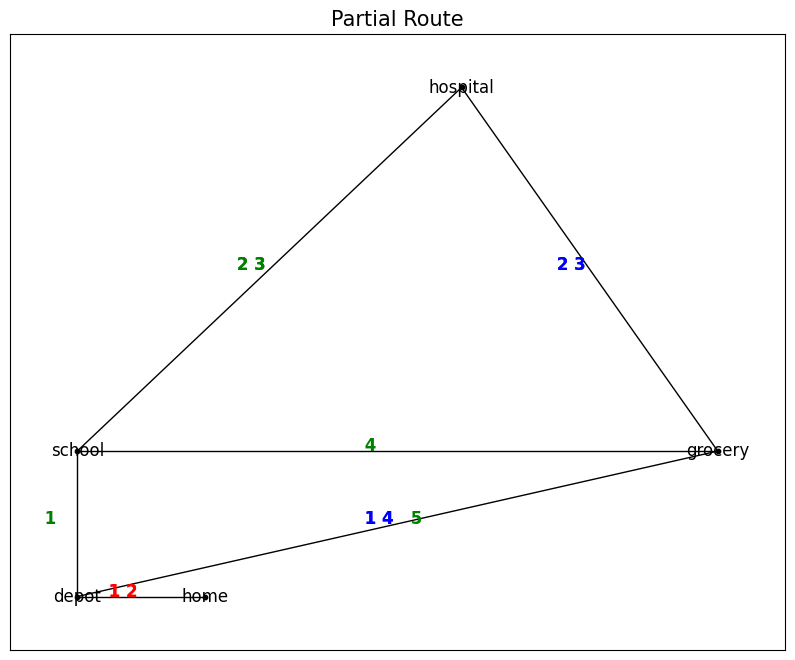

In [28]:
def plot_routes(G, routes):
    colors = ['blue', 'red', 'green', 'purple']
    nx.set_edge_attributes(G,"", "plot_sequence")

    plt.figure(figsize=(10, 8))
    nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True)

    for color, route in enumerate(routes):
        visited = []
        for i, edge in enumerate(route):
            # if we've visited the arc already on this route, add to plot_sequence. otherwise create new
            if((edge[0], edge[1]) not in visited and (edge[1], edge[0]) not in visited):
                new_plot_sequence = ""
                for j in range(len(G[edge[0]][edge[1]]["plot_sequence"])):
                    new_plot_sequence += "  "
                G[edge[0]][edge[1]]['plot_sequence'] = new_plot_sequence + ' ' + str(i+1)
            else:
                G[edge[0]][edge[1]]['plot_sequence'] += ' ' + str(i+1)
            visited.append(edge)
        for edge in route:
            x = (node_positions[edge[0]][0] + node_positions[edge[1]][0]) / 2 - .3
            y = (node_positions[edge[0]][1] + node_positions[edge[1]][1]) / 2
            plt.text(x, y, G[edge[0]][edge[1]]["plot_sequence"], color=colors[color], fontsize=12, fontweight = 'bold')
    plt.title('Partial Route', size=15)
    plt.show()

plot_routes(G_copy, routes)

In [29]:
def turn_penalty(edge1, edge2):
    penalties = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}
    node1 = edge1[0]
    node2 = edge1[1]
    node3 = edge2[1]

    v_x = G.nodes[node2]['x']-G.nodes[node1]['x']
    v_y = G.nodes[node2]['y']-G.nodes[node1]['y']

    w_x = G.nodes[node3]['x']-G.nodes[node2]['x']
    w_y = G.nodes[node3]['y']-G.nodes[node2]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle(v,w)
    return penalties[turn_direction(theta)]

## Evaluating Tour Cost

Considerations: Priority. Number of deadheaded routes. Number of returns required to depot (total number of routes). Number of left turns. 

In [30]:
def routes_cost_updated(routes, NUMROUTES_PENALTY, DEADHEAD_PENALTY):
    cost = 0
    time = 0
    for route in routes:
        for i in range(len(route)):
            edge = route[i]

            # penalize the turn
            if i+1 < len(route):
                cost += turn_penalty(edge, route[i+1])

            # penalize priority and distance
            edge_data = G[edge[0]][edge[1]]
            
            time += edge_data['time']
            priority_cost = edge_data['priority'] * time
            
            cost += edge_data['distance']+priority_cost
        # penalize number of returns to depot
        cost += NUMROUTES_PENALTY

    # penalize deadheading
    for edge in G.edges(data=True):
        cost += edge[2]['deadheading_passes']*DEADHEAD_PENALTY
    return cost

routes_cost_updated(routes, 1, 1)


583

### Testing Edge Case 1 - Immediate Road has High Priority

What if one of the roads leading off the depot has an extremely high priority? The route should almost always go there first


In [31]:
# define initial conditions
curr_node = 'depot' # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_edge = G.copy()
G_dual = create_dual(G_edge)
curr_salt = 10
routes_edge = []
partial_route = list()
number_of_routes = 0

G_edge["depot"]["school"]["priority"] = 1000

config_graph_attributes(G_edge)
while all_serviced(G_edge) == False:
    partial_route = RCA(G_edge, G_dual, curr_node, alpha, selection_weights, partial_route)
    routes_edge.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = 'depot'
    partial_route = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes_edge)))
for route in routes_edge:
    for edge in route:
        print(edge)
    
    print("*****\n")


randomizing
Weights [0.43764706 0.56235294] prev node is none? False
Degree weights [0.98823529 0.01176471]
choice:  grocery hospital
RCl was  [('grocery', 'school'), ('grocery', 'hospital')]
randomizing
randomizing
Weights [0.82618336 0.17381664] prev node is none? False
Degree weights [0.99404171 0.00595829]
choice:  school depot
RCl was  [('school', 'depot'), ('school', 'hospital')]
Weights [1.] prev node is none? True
Degree weights [1.]
choice:  depot home
RCl was  [('depot', 'home')]
current node is  home path is  [('depot', 'home'), ('depot', 'school')]
currnode is  depot
current node is  depot path is  [('depot', 'school')]
currnode is  school
randomizing
Weights [1.] prev node is none? False
Degree weights [1.]
choice:  hospital school
RCl was  [('hospital', 'school')]
Number of routes:3
('depot', 'grocery')
('grocery', 'hospital')
('hospital', 'grocery')
('grocery', 'school')
('school', 'depot')
*****

('depot', 'home')
('home', 'depot')
*****

('depot', 'school')
('school', 

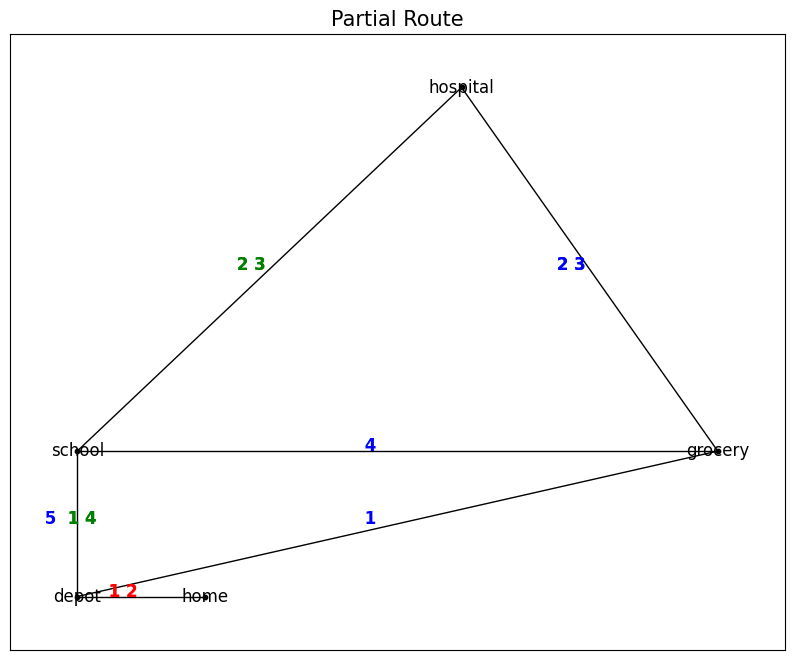

In [32]:
plot_routes(G_edge, routes_edge)

### Testing Edge Case 2 - Road Separated by One Neighbor Has High Priority

What if a next-neighboring road has high priority? Then we want to visit the node that will lead us to that high prioirty road.


In [33]:
# define initial conditions
curr_node = 'depot' # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_edge = G.copy()
G_dual = create_dual(G_edge)
curr_salt = 10
routes_edge = []
partial_route = list()
number_of_routes = 0

G_edge["grocery"]["hospital"]["priority"] = 1000

config_graph_attributes(G_edge)
for node in G_edge.nodes(data=True):
    print(node)
while all_serviced(G_edge) == False:
    partial_route = RCA(G_edge, G_dual, curr_node, alpha, selection_weights, partial_route)
    routes_edge.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = 'depot'
    partial_route = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes_edge)))
for route in routes_edge:
    for edge in route:
        print(edge)
    
    print("*****\n")


('depot', {'x': 0, 'y': 0, 'effective_degree': 3, 'weighted_degree': 4})
('home', {'x': 1, 'y': 0, 'effective_degree': 1, 'weighted_degree': 1})
('school', {'x': 0, 'y': 2, 'effective_degree': 4, 'weighted_degree': 9})
('grocery', {'x': 5, 'y': 2, 'effective_degree': 4, 'weighted_degree': 2004})
('hospital', {'x': 3, 'y': 7, 'effective_degree': 4, 'weighted_degree': 2006})
Weights [0.16683217 0.16815624 0.66501159] prev node is none? True
Degree weights [4.96524330e-04 4.46871897e-03 9.95034757e-01]
choice:  depot grocery
RCl was  [('depot', 'home'), ('depot', 'school'), ('depot', 'grocery')]
randomizing
Weights [0.26964349 0.73035651] prev node is none? False
Degree weights [0.00890208 0.99109792]
choice:  hospital grocery
RCl was  [('hospital', 'school'), ('hospital', 'grocery')]
Weights [1.] prev node is none? False
Degree weights [1.]
choice:  grocery school
RCl was  [('grocery', 'school')]
Weights [0.37857143 0.62142857] prev node is none? False
Degree weights [0.25 0.75]
choice: 

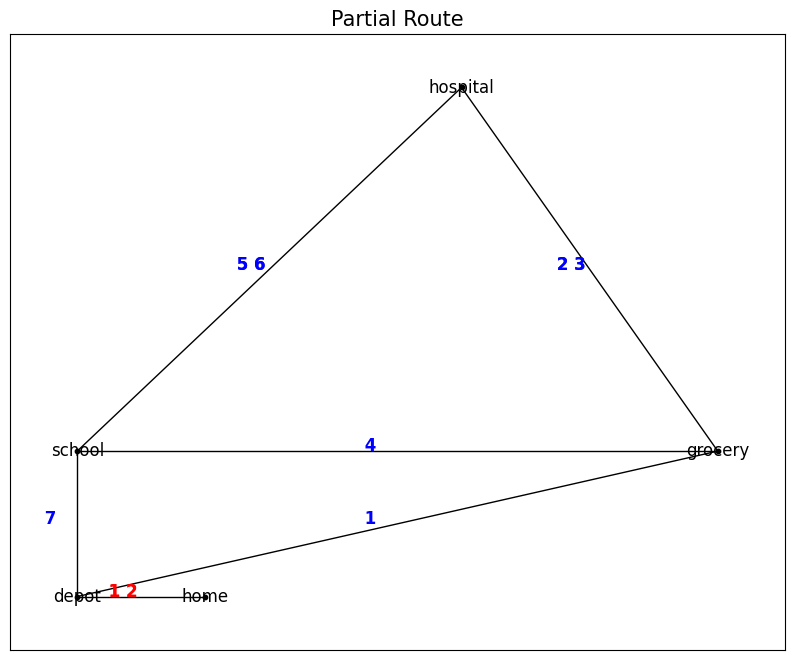

In [34]:
plot_routes(G_edge, routes_edge)

In [35]:
def print_graph_attributes(G):
    for node in G.nodes(data=True):
        print(node)

    for edge in G.edges(data=True):
        print(edge)

### Weighting Shortest Paths by Turns

Approach: Create a psuedo-dual graph. See [this paper](https://www.deepdyve.com/lp/springer-journals/modeling-costs-of-turns-in-route-planning-aBXaJq6noV?)

In [36]:
def identify_cost(G_primal, G_dual, node1, node2):
    '''
    Identifies the cost of traversing from edge1 to edge2
    '''
    # cost is the sum of the weights of the two nodes in the graph (which correspond to edges in the oringal)
    cost = G_dual.nodes[node1]['weight'] + G_dual.nodes[node2]['weight']

    # add the turn penalty cost
    turn_penalty = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}

    first_node = 0
    second_node = 0
    third_node = 0

    # identify which way the edges are being traversed. need to traverse node1->common->node2
    if node1[1] == node2[0]:
        # common node in the middle, traverse by going node1->common->node2
        first_node = node1[0]
        second_node = node1[1]
        third_node = node2[1]
    
    elif node1[0] == node2[1]:
        # common node at the start fo first edge and end of second edge
        first_node = node1[1]
        second_node = node1[0]
        third_node = node2[0]
    
    elif node1[0] == node2[0]:
        # common node the first node of both edges, traverse the first edge first
        first_node = node1[1]
        second_node = node1[0]
        third_node = node2[1]

    elif node1[1] == node2[1]:
        # common node the second node of both edges
        first_node = node1[0]
        second_node = node1[1]
        third_node = node2[0]
    

    v_x = G_primal.nodes[second_node]['x']-G_primal.nodes[first_node]['x']
    v_y = G_primal.nodes[second_node]['y']-G_primal.nodes[first_node]['y']

    w_x = G_primal.nodes[third_node]['x']-G_primal.nodes[second_node]['x']
    w_y = G_primal.nodes[third_node]['y']-G_primal.nodes[second_node]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle(v,w)
    cost += turn_penalty[turn_direction(theta)]

    return cost

In [37]:
G_dual = nx.DiGraph(name="pseudo-dual")

# Create nodes in G_dual for each edge in G
for edge in G.edges():
    G_dual.add_node(edge, weight=G[edge[0]][edge[1]]['distance'])

# Create edges in G_dual to represent connections between two edges in G
for edge1 in G.edges():
    for edge2 in G.edges():
        if edge1 != edge2:
            if edge1[1] == edge2[0] or edge1[0] == edge2[0] or edge1[1] == edge2[1]:

                # get the weights for traversing in both directions
                weight1 = identify_cost(G, G_dual, edge1, edge2)
                weight2 = identify_cost(G, G_dual, edge2, edge1)

                # add edges to graph
                G_dual.add_edge(edge1, edge2, weight=weight1)
                G_dual.add_edge(edge2, edge1, weight=weight2)
                
print(G_dual)
print_graph_attributes(G_dual)

DiGraph named 'pseudo-dual' with 6 nodes and 20 edges
(('depot', 'home'), {'weight': 1})
(('depot', 'school'), {'weight': 2})
(('depot', 'grocery'), {'weight': 7})
(('school', 'grocery'), {'weight': 5})
(('school', 'hospital'), {'weight': 3})
(('grocery', 'hospital'), {'weight': 3})
(('depot', 'home'), ('depot', 'school'), {'weight': 4})
(('depot', 'home'), ('depot', 'grocery'), {'weight': 12})
(('depot', 'school'), ('depot', 'home'), {'weight': 5})
(('depot', 'school'), ('depot', 'grocery'), {'weight': 12})
(('depot', 'school'), ('school', 'grocery'), {'weight': 8})
(('depot', 'school'), ('school', 'hospital'), {'weight': 6})
(('depot', 'grocery'), ('depot', 'home'), {'weight': 12})
(('depot', 'grocery'), ('depot', 'school'), {'weight': 11})
(('depot', 'grocery'), ('school', 'grocery'), {'weight': 16})
(('depot', 'grocery'), ('grocery', 'hospital'), {'weight': 12})
(('school', 'grocery'), ('depot', 'school'), {'weight': 9})
(('school', 'grocery'), ('depot', 'grocery'), {'weight': 16})

Each node carries a weight corresponding to the distance weight of the edges in the original graph. The edge weights in the dual graph are the corresponding node weight + an additional penalty for turning.

### How does NetworkX's line_graph function compare?

Similar, but half the edges. We need twice the edges because the cost is different depending on the order of traversal

In [45]:
L = nx.line_graph(G)
print(L)
print_graph_attributes(L)

Graph with 6 nodes and 10 edges
(('depot', 'home'), {})
(('depot', 'school'), {})
(('school', 'grocery'), {})
(('school', 'hospital'), {})
(('depot', 'grocery'), {})
(('grocery', 'hospital'), {})
(('depot', 'home'), ('depot', 'school'), {})
(('depot', 'home'), ('depot', 'grocery'), {})
(('depot', 'school'), ('school', 'grocery'), {})
(('depot', 'school'), ('school', 'hospital'), {})
(('depot', 'school'), ('depot', 'grocery'), {})
(('school', 'grocery'), ('school', 'hospital'), {})
(('school', 'grocery'), ('depot', 'grocery'), {})
(('school', 'grocery'), ('grocery', 'hospital'), {})
(('school', 'hospital'), ('grocery', 'hospital'), {})
(('depot', 'grocery'), ('grocery', 'hospital'), {})


Plotting (doesn't quite work b/c only plots one set of weights)

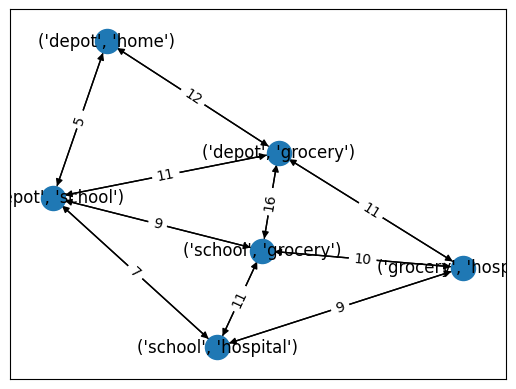

In [39]:
# Set the seed for the spring layout
spring_pos = nx.spring_layout(G_dual, seed=1)

# Draw the graph using the spring layout
nx.draw_networkx(G_dual, pos=spring_pos, with_labels=True)

# print edge weights on the plot
edge_labels = nx.get_edge_attributes(G_dual, 'weight')

nx.draw_networkx_edge_labels(G_dual, pos=spring_pos, edge_labels=edge_labels)
plt.show()

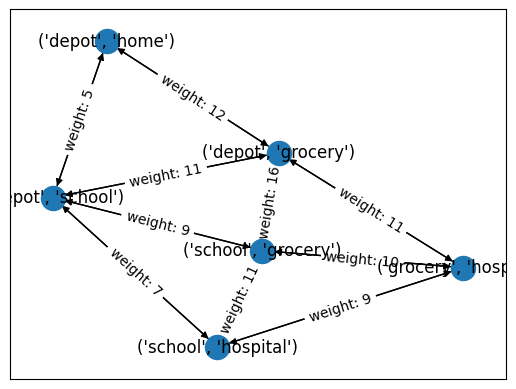

In [40]:
# Set the seed for the spring layout
spring_pos = nx.spring_layout(G_dual, seed=1)

# Draw the graph using the spring layout
nx.draw_networkx(G_dual, pos=spring_pos, with_labels=True)

# Get edge attributes
edge_labels = dict(((u, v), d) for u, v, d in G_dual.edges(data=True))

# Create a label for each edge
for ((u, v), d) in edge_labels.items():
    labels = ', '.join(f'{k}: {v}' for k, v in d.items())
    edge_labels[(u, v)] = labels

# Draw edge labels
nx.draw_networkx_edge_labels(G_dual, pos=spring_pos, edge_labels=edge_labels)

plt.show()

## Finding Shortest Paths with This Representation

This becomes a multi-source, multi-destination shortest path problem. To solve as a single source problem, we need to introduce virtual nodes. Then use [one of these functions](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html) to find shortest paths between all pairs.

Example: shortest path from depot to hospital

O(V) to identify and add virtual source node and virtual target node(s) (multiple if multiple destinations).

In [41]:
G_dual_paths = G_dual.copy()

# add source and target nodes
G_dual_paths.add_node("depot_source", weight=0)
G_dual_paths.add_node("hospital_target", weight=0)

# add edges connecting source and targets to valid gateways
for node in G_dual_paths.nodes():
    # potential source link
    if node[0] == 'depot' or node[1] == 'depot':
        G_dual_paths.add_edge("depot_source", node, weight=0)
    elif node[0] == 'hospital' or node[1] == 'hospital':
        G_dual_paths.add_edge(node, "hospital_target", weight=0)

nx.shortest_path(G_dual_paths, "depot_source", "hospital_target", weight="weight")

['depot_source',
 ('depot', 'school'),
 ('school', 'hospital'),
 'hospital_target']

Example 2: Shortest path from depot to all other nodes

Complexity: O(V) to augment graph. Add V nodes and 4V edges.
Then for djistraks: $O(V^2 \log E)$ for each search. 

Total $O(V^3 \log E)$

In [42]:
G_dual_paths_all = G_dual.copy()

targets = list()

# add source and target nodes
for node in G:
    G_dual_paths_all.add_node(str(node) + "_source", weight=0)
    targets.append(str(node) + "_source")
# add edges connecting source and targets to valid gateways
for node in G_dual_paths_all.nodes():

    # skip the source nodes which are strings. The other nodes are tuples
    if (type(node) == str):
        continue
    G_dual_paths_all.add_edge(str(node[0]) + "_source", node, weight=0)
    G_dual_paths_all.add_edge(str(node[1]) + "_source", node, weight=0)

    G_dual_paths_all.add_edge(node, str(node[0]) + "_source", weight=0)
    G_dual_paths_all.add_edge(node, str(node[1]) + "_source", weight=0)


for target in targets:
    print(target)
    path = nx.dijkstra_path(G_dual_paths_all, "home_source", target, weight="weight")
    print(path)
    


depot_source
['home_source', ('depot', 'home'), 'depot_source']
home_source
['home_source']
school_source
['home_source', ('depot', 'home'), 'depot_source', ('depot', 'school'), 'school_source']
grocery_source
['home_source', ('depot', 'home'), 'depot_source', ('depot', 'grocery'), 'grocery_source']
hospital_source
['home_source', ('depot', 'home'), 'depot_source', ('depot', 'school'), 'school_source', ('school', 'hospital'), 'hospital_source']


## Applying New Shortest Paths to RCA

In [43]:
def move_between_nodes(G, G_dual, node1, node2, route_up_to_now):
    '''
    Moves between two nodes via the shortest path, updating any required arcs along the way. 
    Works for non-multigraphs. Requires modification when doing it for multigraphs since floyd_warshall
    only returns nodes, not edges in the shortest path.
    '''
    node_path = nx.dijkstra_path(G_dual, str(node1)+"_source", str(node2)+"_source", weight="weight")
    
    edges = [edge for edge in node_path if type(edge) == tuple] # ignore source nodes

    for edge in edges:
        visit_arc(G, edge, route=route_up_to_now)

In [44]:
def find_nearest_required(G, G_dual, node):
    '''
    Finds the path to the nearest node with a required arc to traverse.
    '''
    dists = dict()
    for target in G.nodes():
        distance = nx.dijkstra_path_length(G_dual, node + "_source", target + "_source", weight="weight")
        dists.update(node,distance)
    # loop through the dists array and find the nearest required arc
    min_dist = math.inf
    min_dist_node = None
    for n in G.nodes():
        if n == node:
            continue
        if G.nodes[n]['effective_degree'] > 0 and dists[n] < min_dist:
            # check that the node has an edge to service within salt capacity
            if has_edge_within_capacity(G, n):
                min_dist = dists[n]
                min_dist_node = n
    
    if min_dist_node is None:
        return None
    # reconstruct path
    node_path = nx.dijkstra_path(G_dual, str(node)+"_source", str(min_dist_node)+"_source", weight="weight")
    edges = [edge for edge in node_path if type(edge) == tuple] # ignore source nodes

    return edges
        